# Gradient Boosted Models

Versatile framework to optimize many loss functions. Combining the predictions of multiple base learners to obtain a powerful overall model. The base models are refered to as *weak learners* and the prediction is made in a sequential manner, where the addition of each base model improves the overall model (greedy approach).

It is similar to a Random Survival Forest, in the sense that it relies on multiple base learners to produce an overall prediciton, but differs in how those are combined. While a RSFT fits a set of survival trees and then averages their predictions, a gradient boosted model is constructed sequentially in a greedy stagewise fashion.

## Base Learners

sksurv.ensemble.GradientBoostingSurvivalAnalysis implements gradient boosting with regression tree base learner. It is very versatile and can account for complicated non-linear relationships between features and time to survival.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [2]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

In [4]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.756


In [5]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

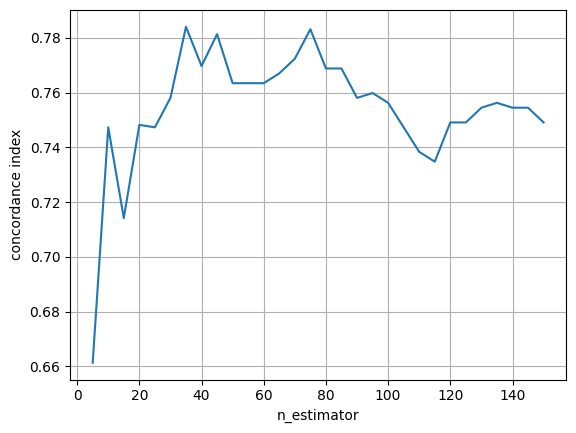

In [6]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

## Accelerated Failure Time Model

The Accelerated Failure Time (AFT) model is an alternative to Cox’s proportional hazards model. The latter assumes that features only influence the hazard function via a constant multiplicative factor. In contrast, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. The figure below depicts the predicted hazard functions of a proportional hazards model in blue and that of an AFT model in orange.

In [7]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.722


## Regularization

The most important parameter in gradient boosting is the number of base learner to use (n_estimators argument). A higher number will lead to a more complex model. However, this can easily lead to overfitting on the training data. The easiest way would be to just use less base estimators, but there are three alternatives to combat overfitting:

- Use a learning_rate less than 1 to restrict the influence of individual base learners, similar to the Ridge penalty.

- Use a non-zero dropout_rate, which forces base learners to also account for some of the previously fitted base learners to be missing.

- Use subsample less than 1 such that each iteration only a portion of the training data is used. This is also known as stochastic gradient boosting.

In [8]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

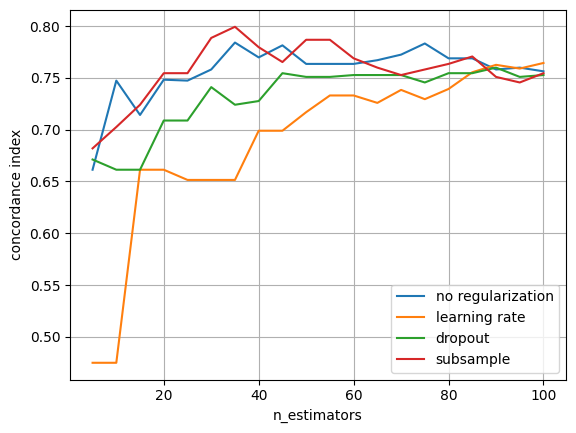

In [9]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)